In [ ]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
tf.random.set_seed(123)

In [ ]:
# we use DIODE: A Dense Indoor and Outdoor Depth Dataset 

annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774638592/2774625282 [==============================] - 49s 0us/step


In [ ]:
# We only use indoor images for training

path = "val/indoors"
filelist = []

for root, dirs, files in os.walk(path):
  for file in files:
    filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")]
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

In [ ]:
df

image  \
234  val/indoors/scene_00021/scan_00188/00021_00188...   
110  val/indoors/scene_00020/scan_00185/00020_00185...   
248  val/indoors/scene_00021/scan_00189/00021_00189...   
9    val/indoors/scene_00019/scan_00183/00019_00183...   
93   val/indoors/scene_00020/scan_00184/00020_00184...   
..                                                 ...   
188  val/indoors/scene_00020/scan_00187/00020_00187...   
71   val/indoors/scene_00019/scan_00183/00019_00183...   
106  val/indoors/scene_00020/scan_00185/00020_00185...   
270  val/indoors/scene_00021/scan_00190/00021_00190...   
102  val/indoors/scene_00020/scan_00185/00020_00185...   

                                                 depth  \
234  val/indoors/scene_00021/scan_00188/00021_00188...   
110  val/indoors/scene_00020/scan_00185/00020_00185...   
248  val/indoors/scene_00021/scan_00189/00021_00189...   
9    val/indoors/scene_00019/scan_00183/00019_00183...   
93   val/indoors/scene_00020/scan_00184/00020_00184...   
..                                                 ...   
188  val/indoors/scene_00020/scan_00187/00020_00187...   
71   val/indoors/scene_00019/scan_00183/00019_00183...   
106  val/indoors/scene_00020/scan_00185/00020_00185...   
270  val/indoors/scene_00021/scan_00190/00021_00190...   
102  val/indoors/scene_00020/scan_00185/00020_00185...   

                                                  mask  
234  val/indoors/scene_00021/scan_00188/00021_00188...  
110  val/indoors/scene_00020/scan_00185/00020_00185...  
248  val/indoors/scene_00021/scan_00189/00021_00189...  
9    val/indoors/scene_00019/scan_00183/00019_00183...  
93   val/indoors/scene_00020/scan_00184/00020_00184...  
..                                                 ...  
188  val/indoors/scene_00020/scan_00187/00020_00187...  
71   val/indoors/scene_00019/scan_00183/00019_00183...  
106  val/indoors/scene_00020/scan_00185/00020_00185...  
270  val/indoors/scene_00021/scan_00190/00021_00190...  
102  val/indoors/scene_00020/scan_00185/00020_00185...  

[325 rows x 3 columns]

In [ ]:
Height = 256
width = 256
lr = 0.0002
epochs = 30
batch_size = 32

In [ ]:
# Using DataGenerator class to define the pipeline

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
      
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data and indices
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)
        return x, y

    def on_epoch_end(self):

        # Updates and shuffles indices after every epoch

        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):

        # Load input image and target depth mask

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )
            
        return x, y


In [ ]:
%matplotlib inline

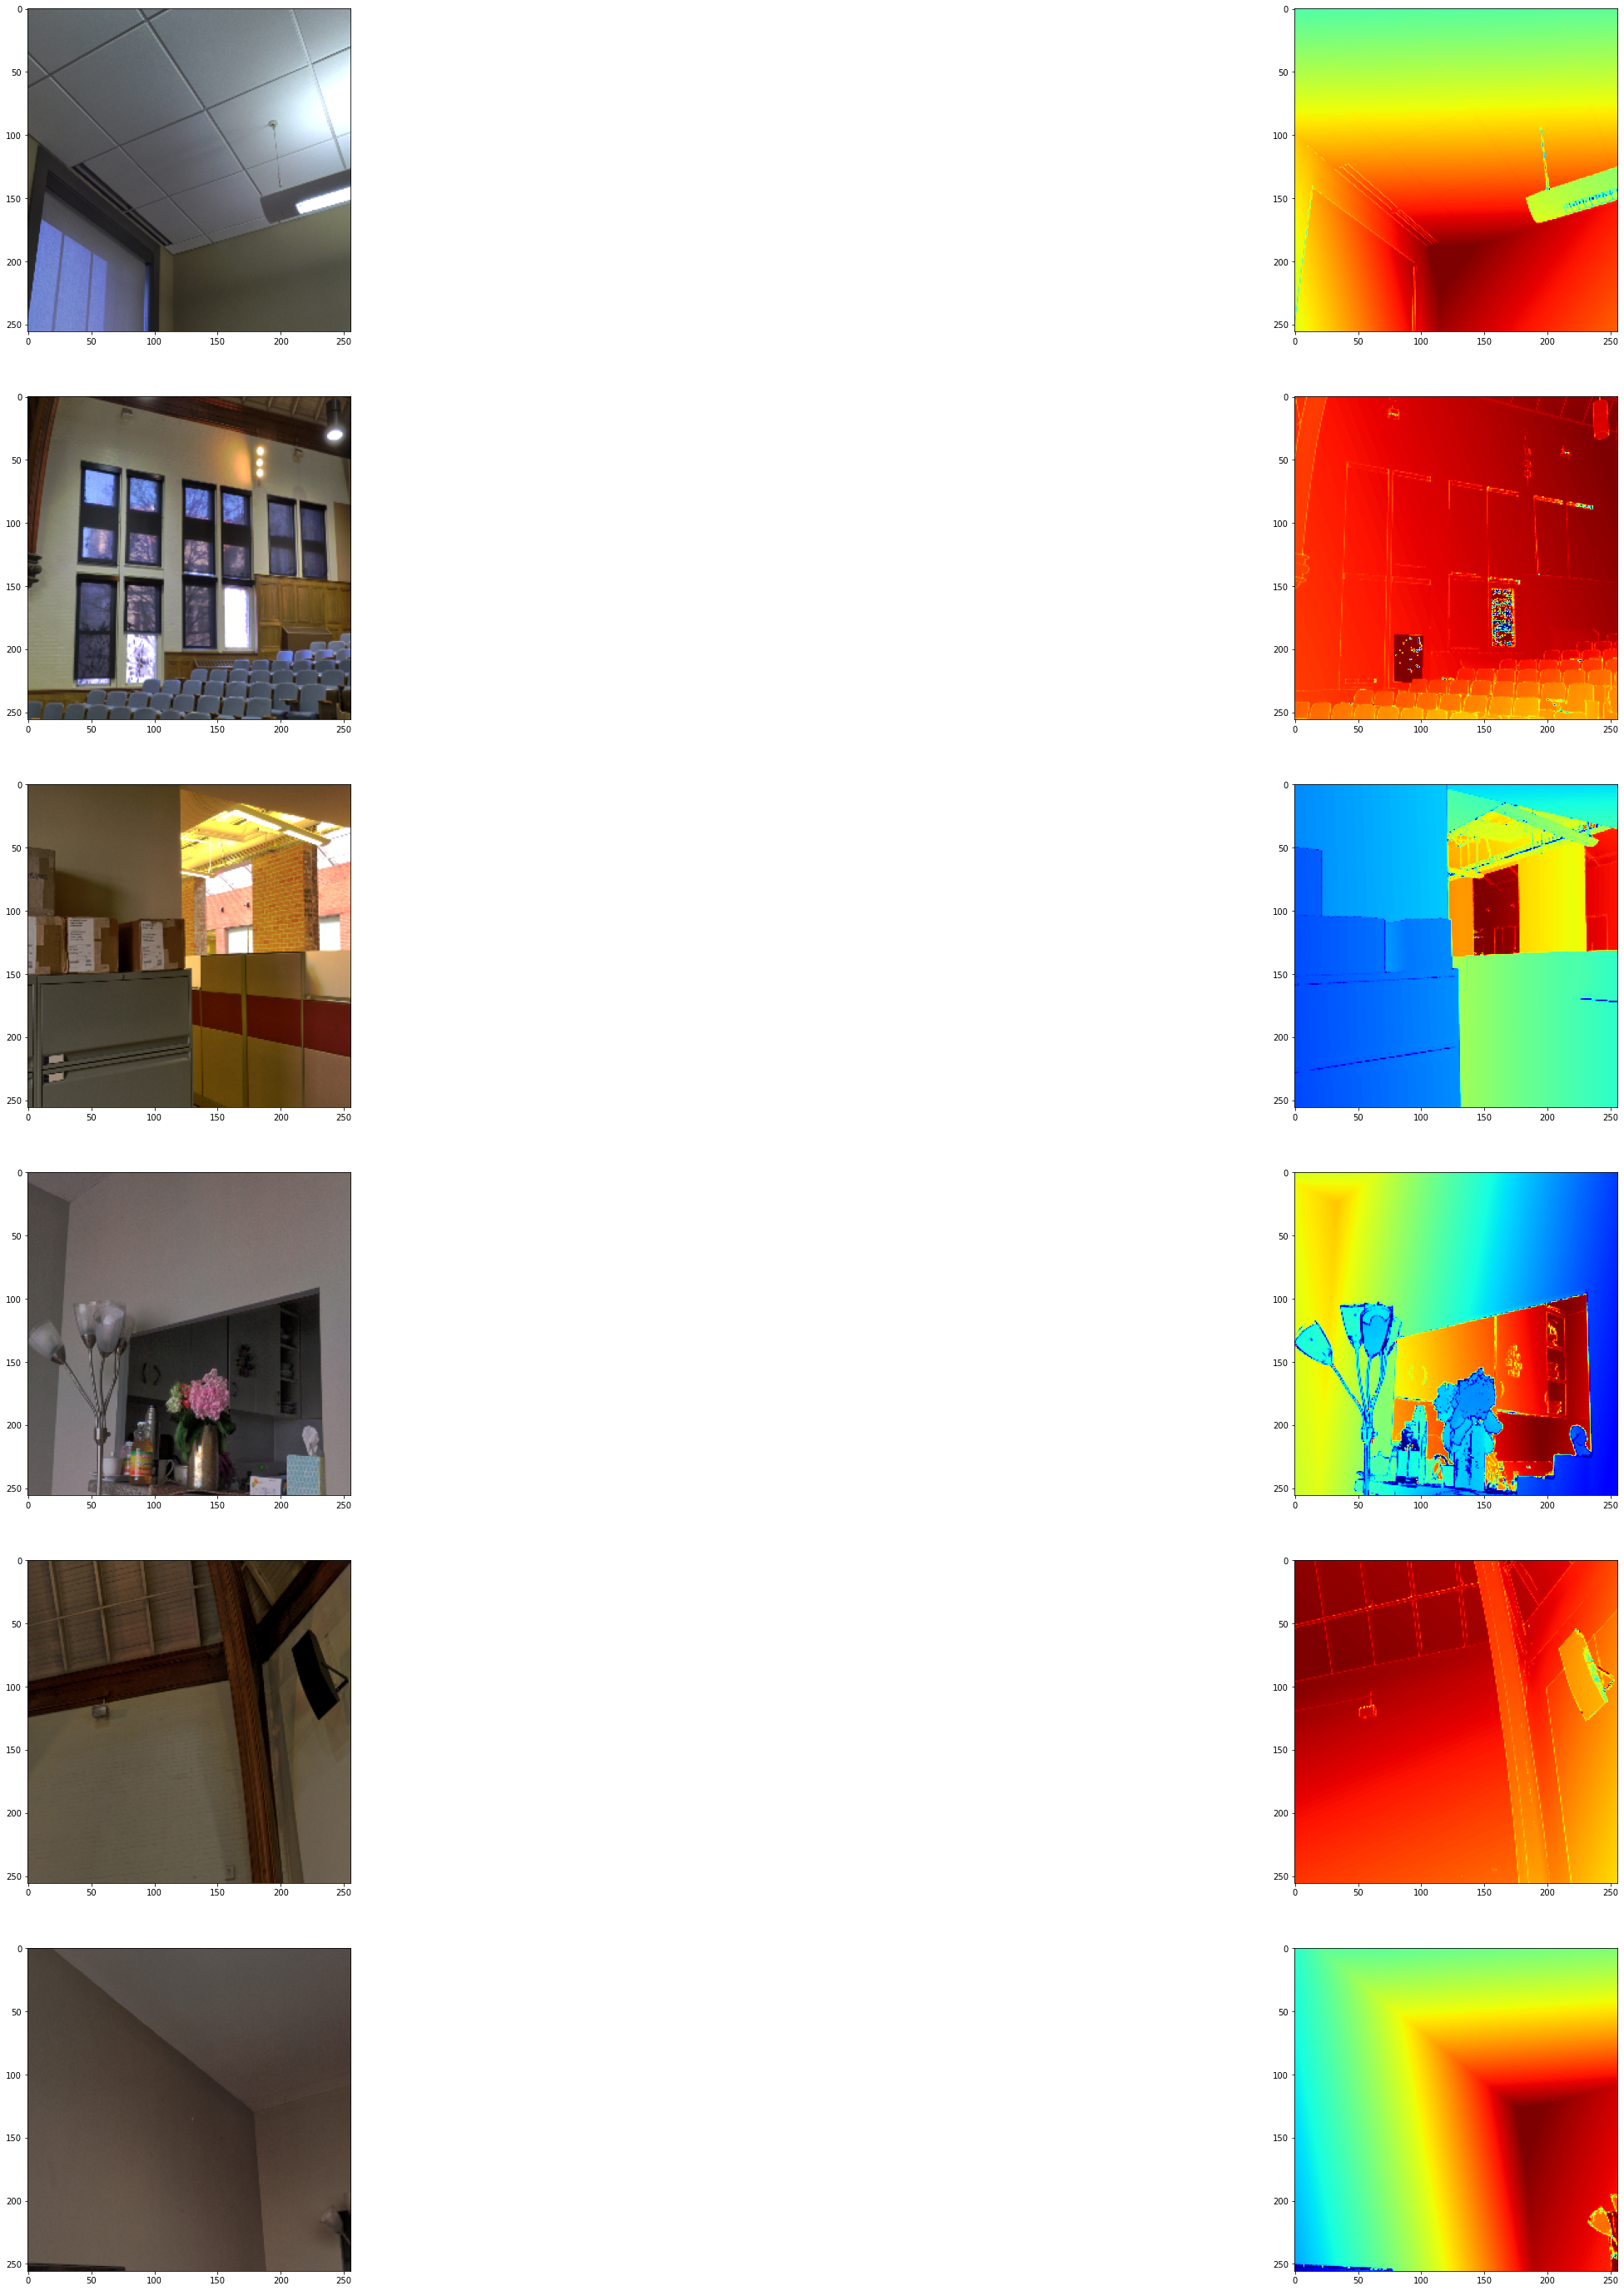

In [ ]:
# visualize samples
def visualize_depth_map(samples, test=False, model=None):
  input, target = samples
  cmap = plt.cm.jet
  cmap.set_bad(color='black')

  if test:
    pred = model.predict(input)
    fig, ax = plt.subplots(6, 3, figsize=(50,50))
    for i in range(6):
      ax[i, 0].imshow(input[i].squeeze())
      ax[i, 1].imshow(target[i].squeeze(), cmap=cmap)
      ax[i, 2].imshow(pred[i].squeeze(), cmap=cmap)

  else:
    fig, ax = plt.subplots(6, 2, figsize=(50,50))
    
    for i in range(6):
      ax[i, 0].imshow(input[i].squeeze())
      ax[i, 1].imshow(target[i].squeeze(), cmap=cmap)

visualize_samples = next(iter(DataGenerator(data=df, batch_size=6, dim=(Height, width))))
visualize_depth_map(visualize_samples)


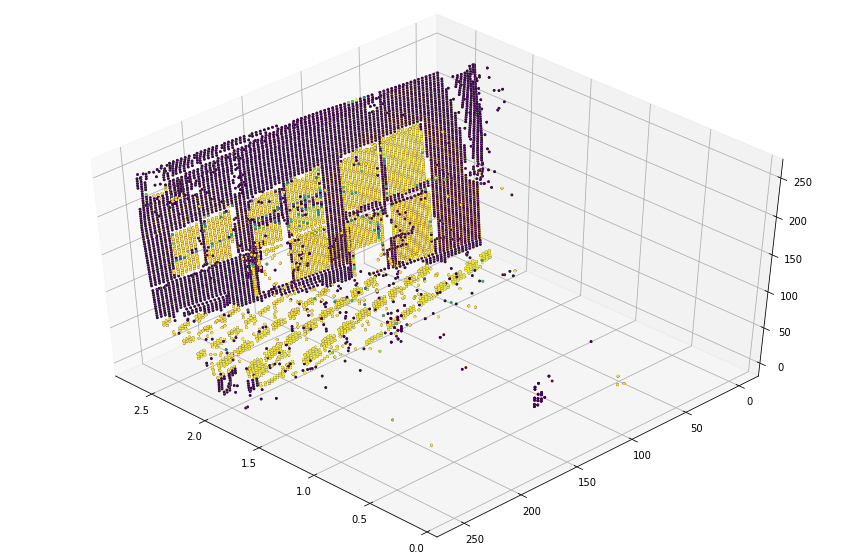

In [ ]:
# 3D point cloud visualization
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

In [ ]:
# Model Building

class DownscaleBlock(layers.Layer):
  def __init__(self, filters, kernel_size=(3,3), padding='same', strides=1,
               **kwargs):
    super().__init__(**kwargs)
    self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
    self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
    self.reluA = layers.LeakyReLU(alpha=0.2)
    self.reluB = layers.LeakyReLU(alpha=0.2)
    self.bn2a = tf.keras.layers.BatchNormalization()
    self.bn2b = tf.keras.layers.BatchNormalization()
    self.pool = layers.MaxPool2D((2,2), (2,2))

  def call(self, input_tensor):
    d = self.convA(input_tensor)
    x = self.bn2a(d)
    x = self.reluA(x)

    x = self.convB(x)
    x = self.bn2b(x)
    x = self.reluB(x)

    x += d
    p = self.pool(x)
    return x, p

class UpscaleBlock(layers.Layer):
  def __init__(self, filters, kernel_size=(3,3), padding='same', strides=1,
               **kwargs):
    super().__init__(**kwargs)
    self.ups = layers.UpSampling2D((2,2))
    self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
    self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
    self.reluA = layers.LeakyReLU(alpha=0.2)
    self.reluB = layers.LeakyReLU(alpha=0.2)
    self.bn2a = tf.keras.layers.BatchNormalization()
    self.bn2b = tf.keras.layers.BatchNormalization()
    self.concat = layers.Concatenate()
  
  def call(self, x, skip):
    x = self.ups(x)
    concat = self.concat([x, skip])
    x = self.convA(concat)
    x = self.bn2a(x)
    x = self.reluA(x)

    x = self.convB(x)
    x = self.bn2b(x)
    x = self.reluB(x)
    
    return x

class BottleNeckBlock(layers.Layer):
  def __init__(self, filters, kernel_size=(3,3), padding='same', strides=1,
               **kwargs):
    super().__init__(**kwargs)
    self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
    self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
    self.reluA = layers.LeakyReLU(alpha=0.2)
    self.reluB = layers.LeakyReLU(alpha=0.2)

  def call(self, x):
    x = self.convA(x)
    x = self.reluA(x)
    x = self.convB(x)
    x = self.reluB(x)

    return x

In [ ]:
# Define Loss nad the model

class DepthEstimationModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.ssim_loss_weight = 0.85
    self.l1_loss_weight = 0.1
    self.edge_loss_weight = 0.9
    self.loss_metric = tf.keras.metrics.Mean(name='loss')

    f = [16, 32, 64, 128, 256]
    self.downscale_blocks = [
        DownscaleBlock(f[0]),
        DownscaleBlock(f[1]),
        DownscaleBlock(f[2]),
        DownscaleBlock(f[3])
    ]

    self.bottleneck = BottleNeckBlock(f[4])

    self.upscale_blocks = [
        UpscaleBlock(f[3]),
        UpscaleBlock(f[2]),
        UpscaleBlock(f[1]),
        UpscaleBlock(f[0])
    ]

    self.conv_layer = layers.Conv2D(1, (1,1), padding='same', activation='tanh')


  def calculate_loss(self, target, pred):

    # Depth smoothness Loss 

    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(pred)

    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(abs(smoothness_y))

    # Structural similarity index

    ssim_loss = tf.reduce_mean(1 - tf.image.ssim(target, pred, max_val=width,
                                                 filter_size=7, k1=0.01**2, k2=0.03**2))
    

    # L1 loss

    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = ((self.ssim_loss_weight * ssim_loss) + 
            (self.l1_loss_weight * l1_loss) +
            (self.edge_loss_weight * depth_smoothness_loss))
    
    return loss


  @property 
  def metrics(self):
    return [self.loss_metric]

  def train_step(self, batch_data):
    input, target = batch_data
    with tf.GradientTape() as tape:
      pred = self(input, training=True)
      loss = self.calculate_loss(target, pred)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_metric.update_state(loss)
    
    return {
        "loss": self.loss_metric.result()
    }

  def test_step(self, batch_data):
    input, target = batch_data
    pred = self(input, training=False)
    loss = self.calculate_loss(target, pred)
    self.loss_metric.update_state(loss)
    
    return {
        "loss": self.loss_metric.result()
    }


  def call(self, x):

        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottleneck(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [ ]:
# Model training

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False)

model = DepthEstimationModel()

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                              reduction='none')

model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=batch_size, dim=(Height, width)
)
validation_loader = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=batch_size, dim=(Height, width)
)
model.fit(
    train_loader,
    epochs=epochs,
    validation_data=validation_loader,
)

Epoch 1/30
9/9 [==============================] - 235s 24s/step - loss: 0.9350 - val_loss: 1.4203
Epoch 2/30
9/9 [==============================] - 40s 4s/step - loss: 0.7287 - val_loss: 1.1120
Epoch 3/30
9/9 [==============================] - 40s 4s/step - loss: 0.6497 - val_loss: 1.2427
Epoch 4/30
9/9 [==============================] - 40s 4s/step - loss: 0.5080 - val_loss: 1.6000
Epoch 5/30
9/9 [==============================] - 40s 4s/step - loss: 0.4884 - val_loss: nan
Epoch 6/30
9/9 [==============================] - 40s 4s/step - loss: 0.4748 - val_loss: 1.5866
Epoch 7/30
9/9 [==============================] - 40s 4s/step - loss: 0.4578 - val_loss: 1.6202
Epoch 8/30
9/9 [==============================] - 40s 4s/step - loss: 0.4475 - val_loss: 0.6527
Epoch 9/30
9/9 [==============================] - 40s 4s/step - loss: 0.4081 - val_loss: 0.5119
Epoch 10/30
9/9 [==============================] - 40s 4s/step - loss: 0.4418 - val_loss: 0.4056
Epoch 11/30
9/9 [=======================

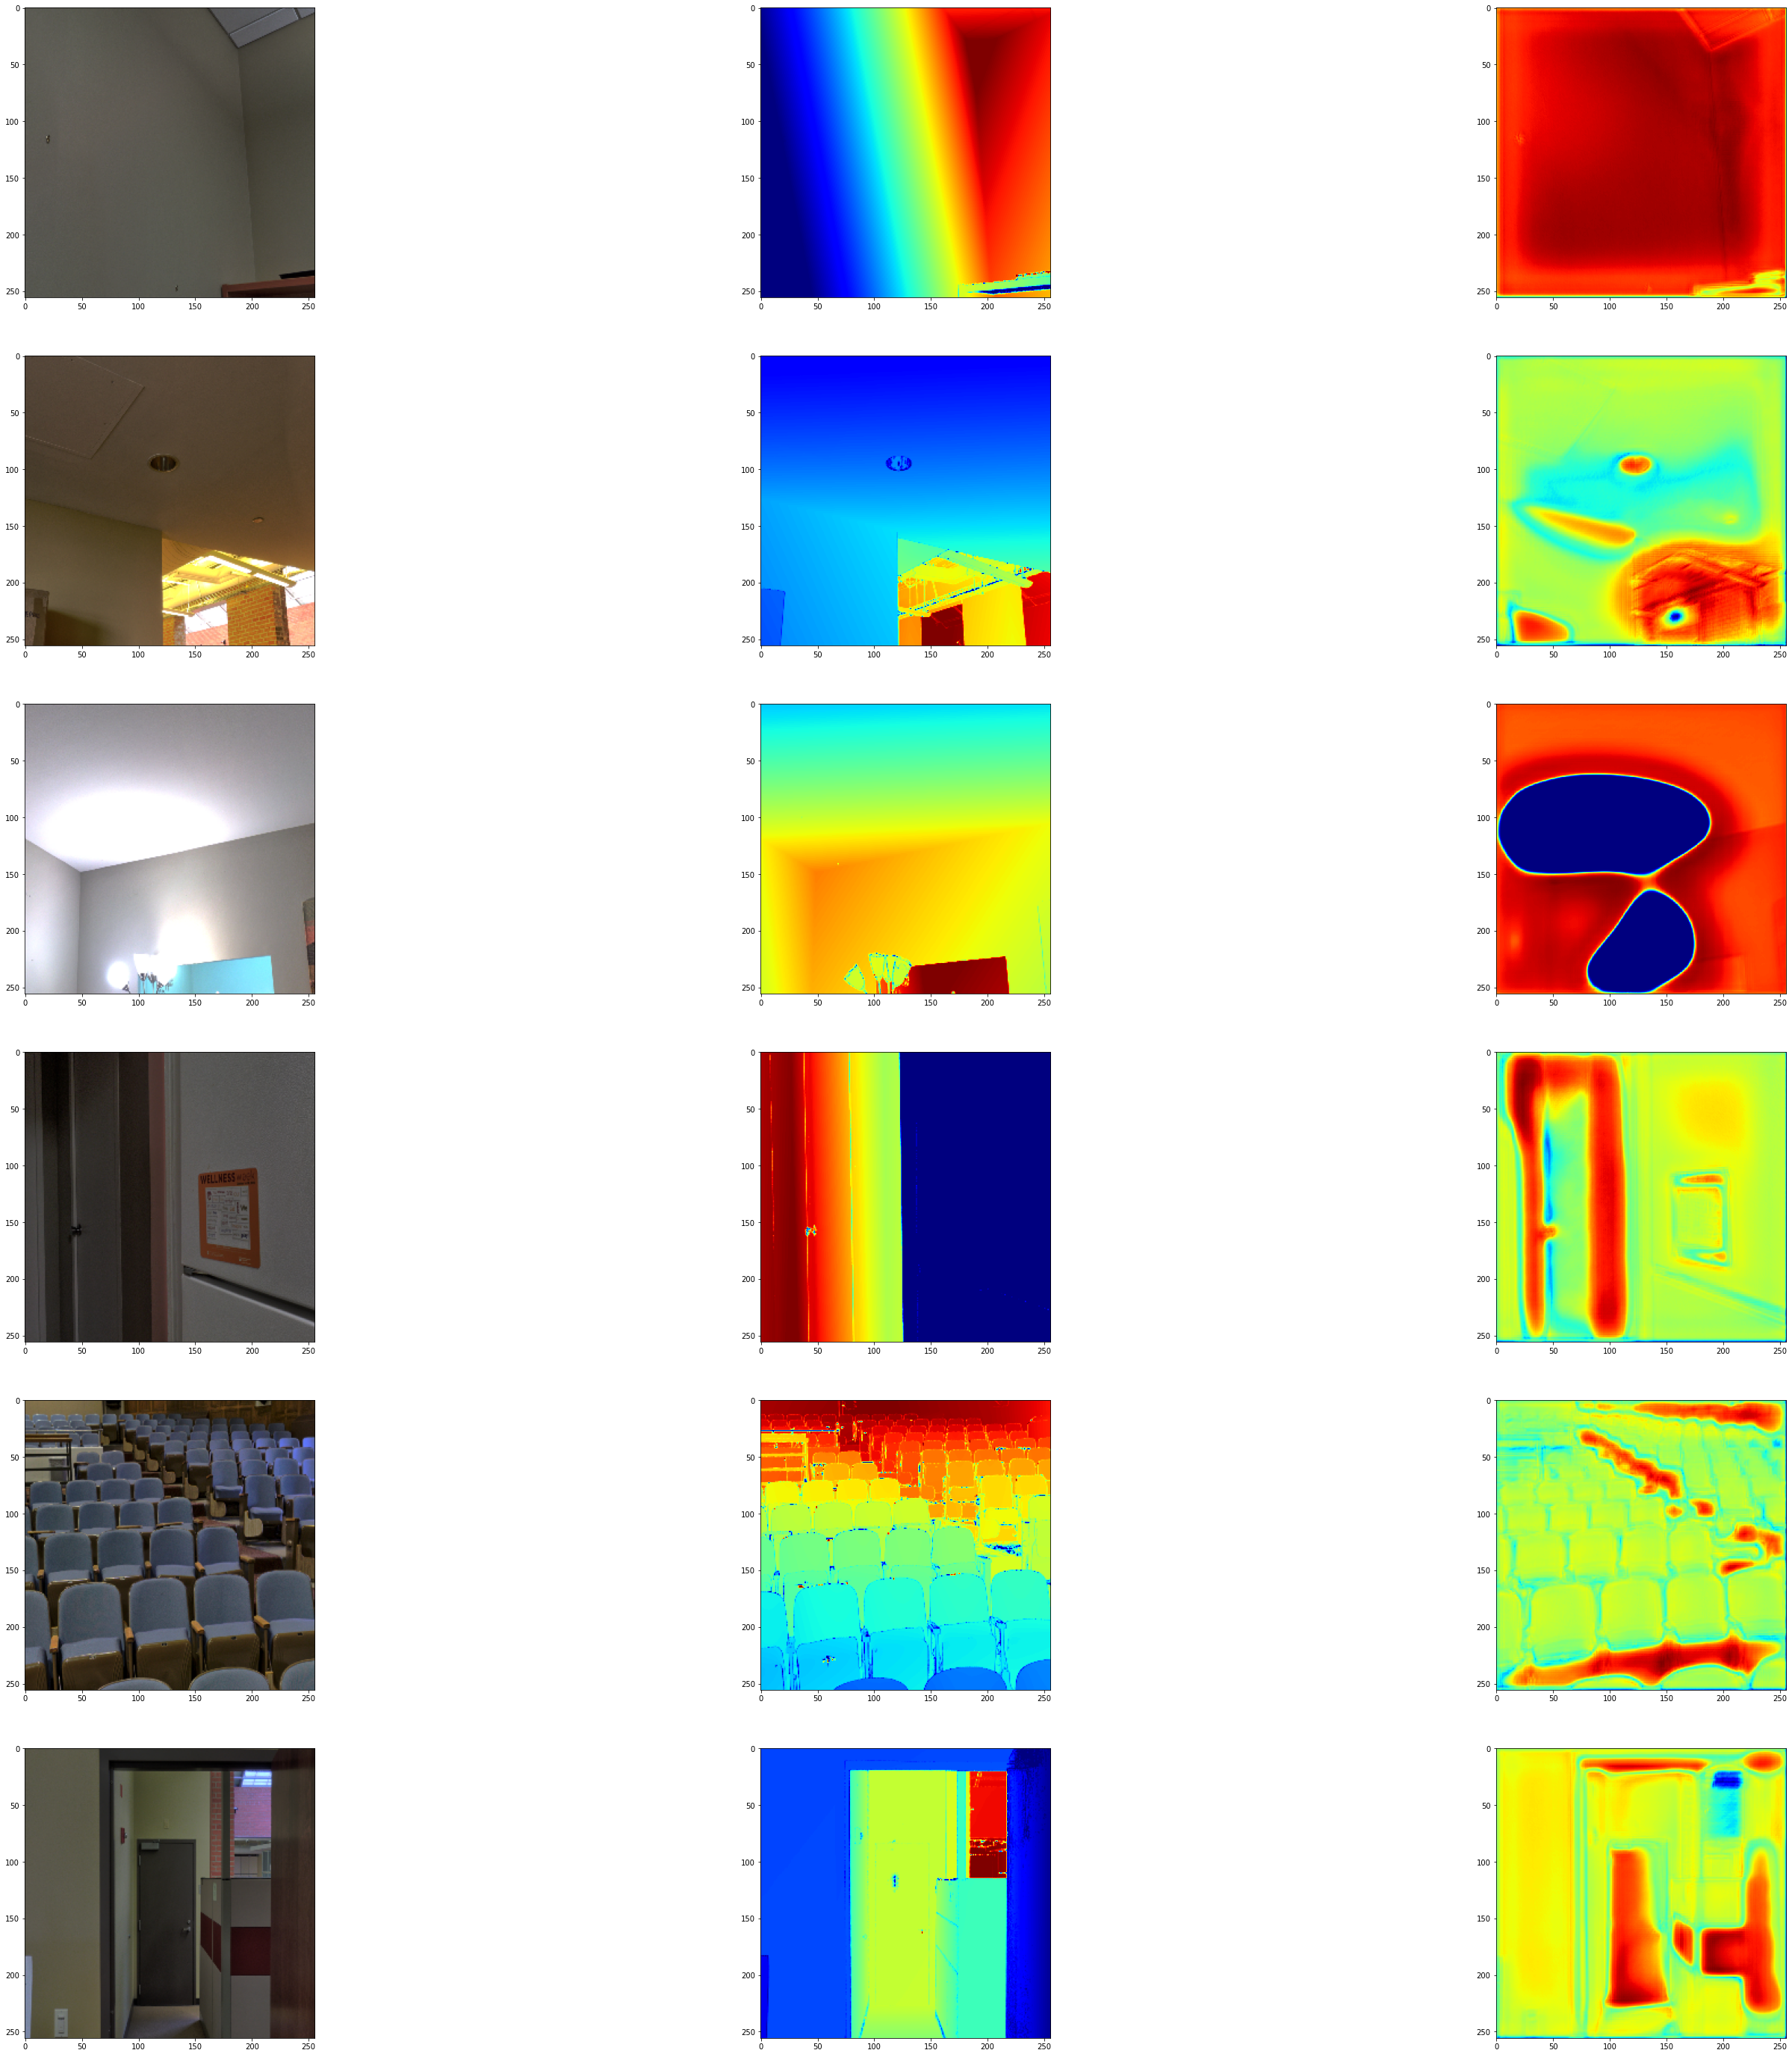

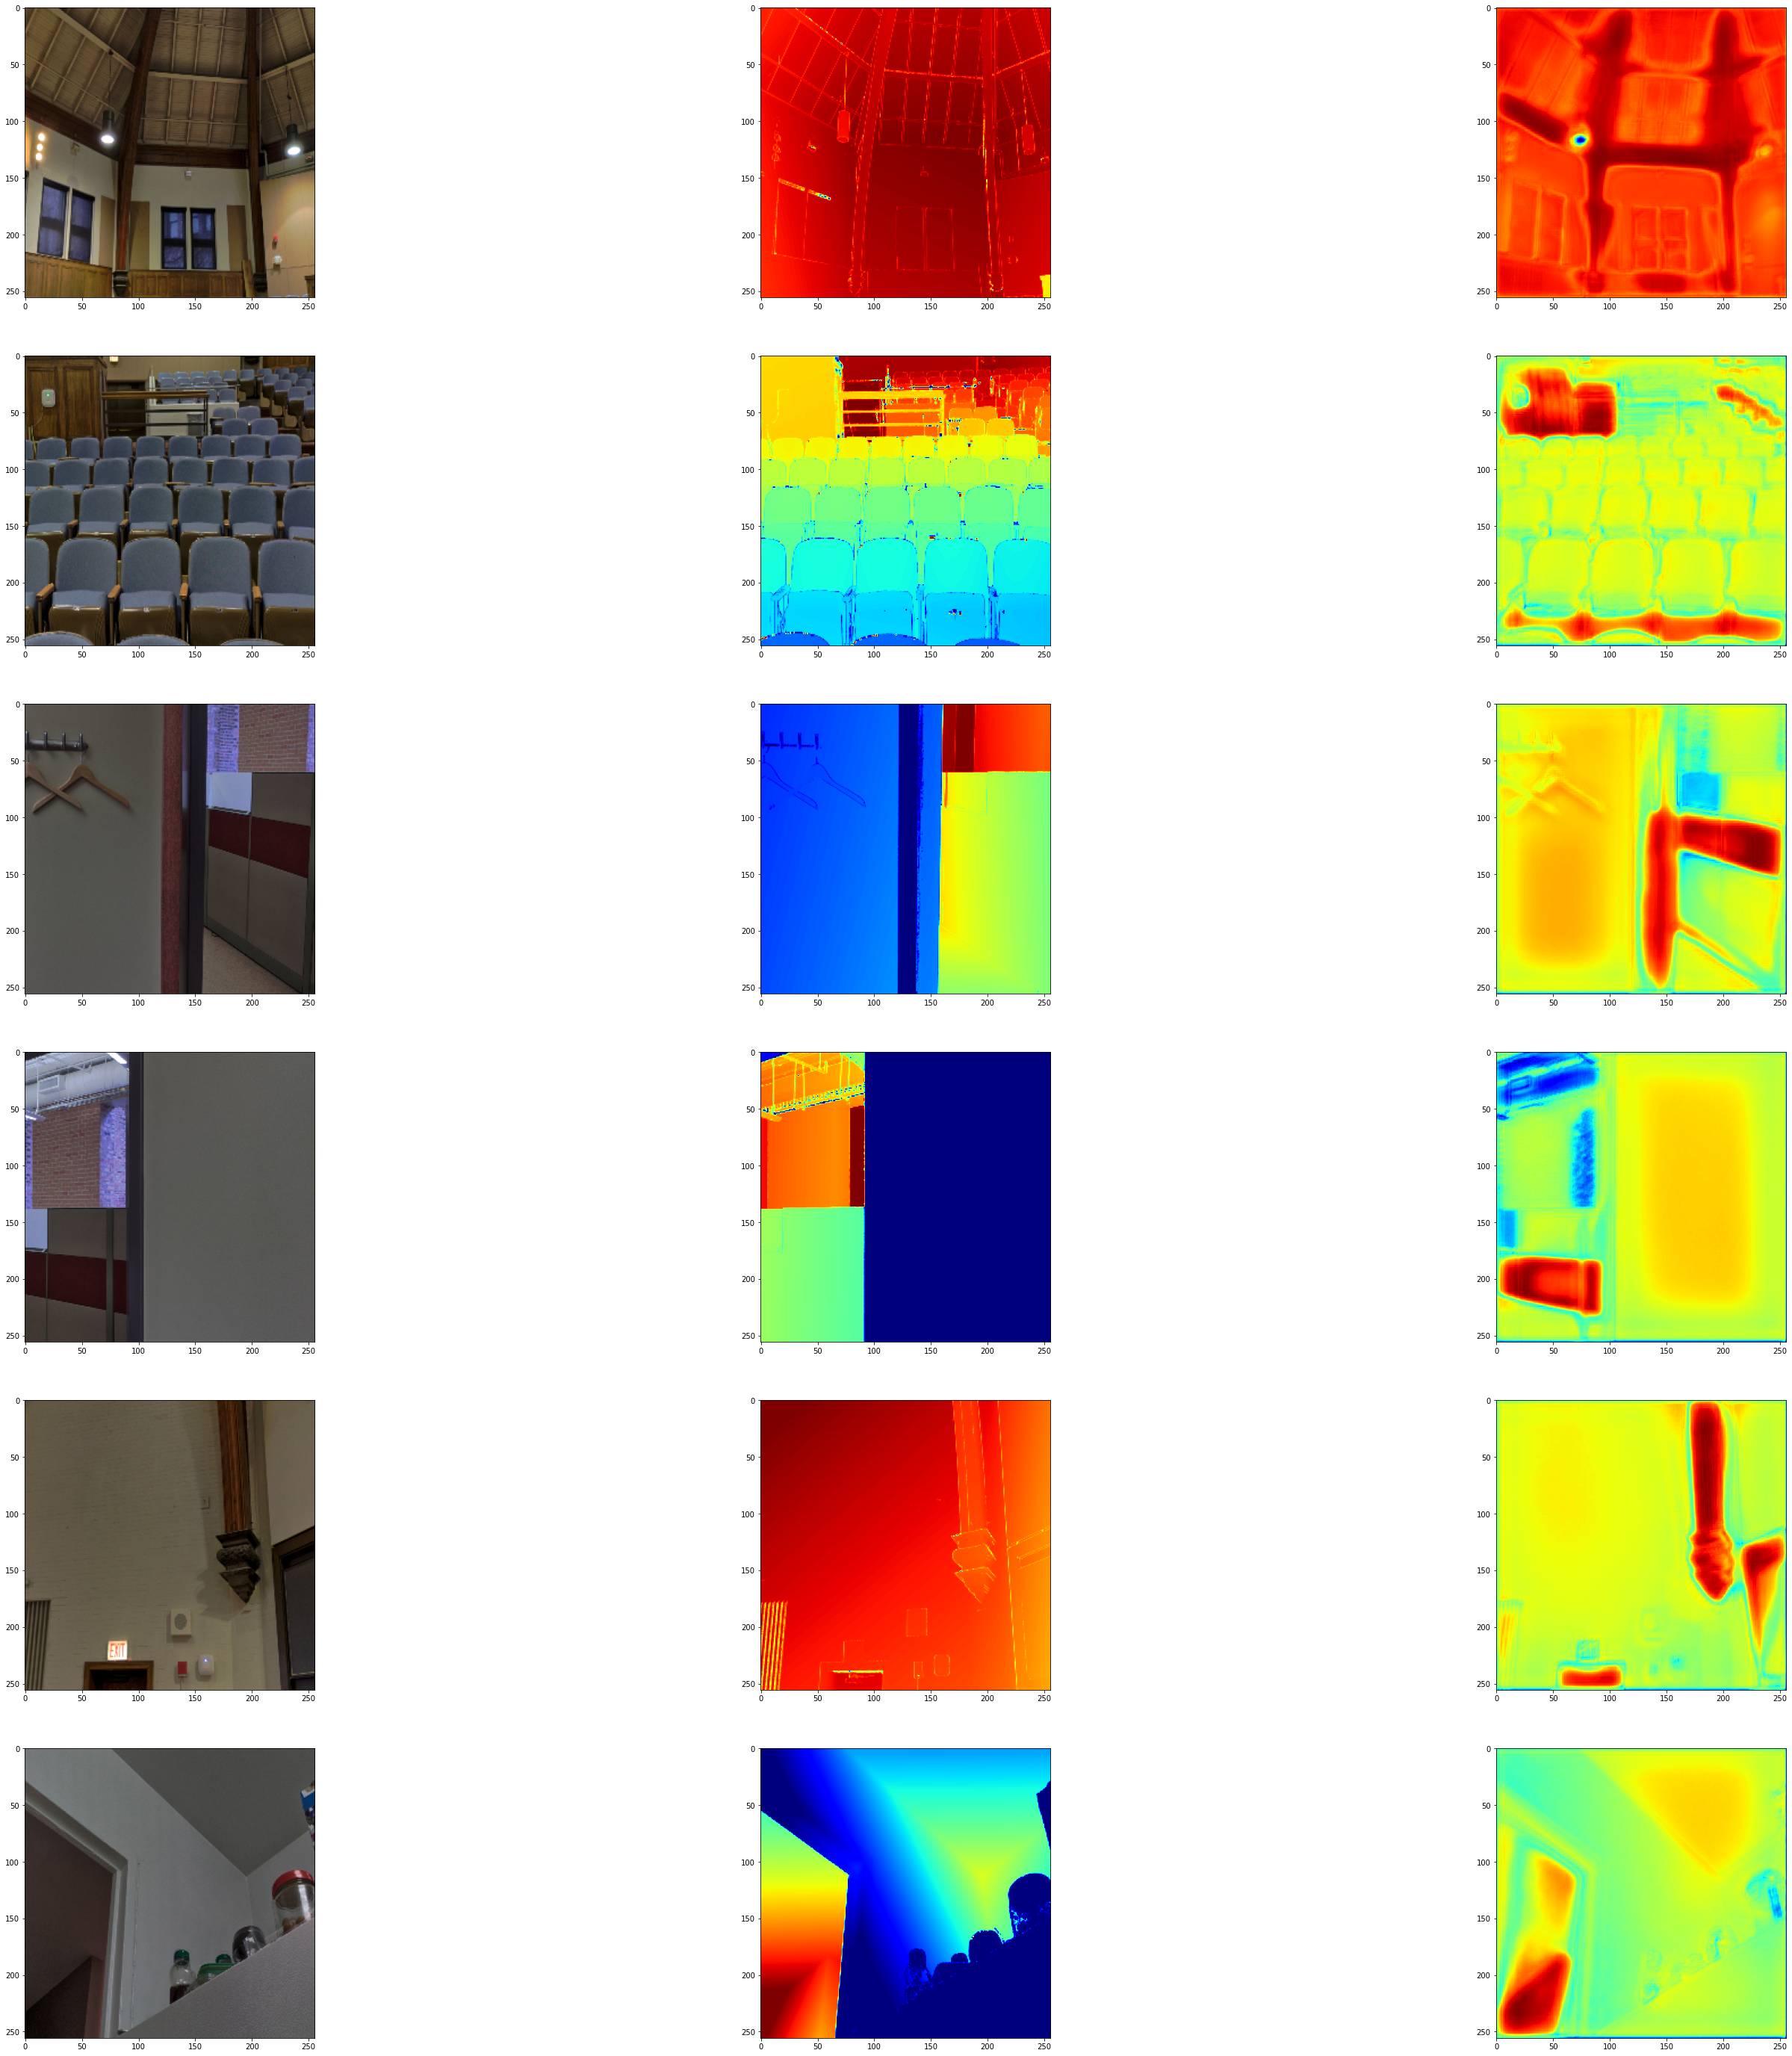

In [14]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(Height, width)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(Height, width)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)